## 1 Merge Root Files

In [ ]:
import Radiography_Library as RadLib

directory = 'BUILD/ROOT'
starts_with = 'Rad_80'
output_name = 'Rad_m_80'

RadLib.Merge_Roots(directory, starts_with, output_name)

## 2. Root to Dataframe

In [ ]:
import Radiography_Library as RadLib

directory = 'BUILD/ROOT/'
root_name_starts = "Rad_m_80_1"

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

x_data, y_data = RadLib.Root_to_Dask(directory, root_name_starts, tree_name, x_branch, y_branch)

## 3. Dask Dataframe to Heatmap

In [ ]:
import Radiography_Library as RadLib

size = 200
log_factor = 0.3

x_shift = 0
y_shift = 0

save_as = ''
htmp_array, xlim, ylim = RadLib.Heatmap_from_Dask(x_data, y_data, size, log_factor, x_shift, y_shift, save_as)

## 4.1. Isolate Bone from Tissue

In [6]:
# LOAD ROOTS

import Radiography_Library as RadLib

directory = 'BUILD/ROOT/'
rootnames = ["FATns40k150M", "FATns80k150M"]
rootnames = ["Rad_0", "Rad_1"]
rootnames = ["Rad_40_4", "Rad_80_4"]

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

x_1, y_1, x_2, y_2 = RadLib.LoadRoots(directory, rootnames, tree_name, x_branch, y_branch)

Dataframes created


In [7]:
# CALCULATE HEATMAPS

import matplotlib.pyplot as plt

x_shift = 0.0
y_shift = 10

size = 200
log_factor = 0.1

low_energy_img, xlim, ylim  = RadLib.Heatmap_from_Dask(x_1, y_1, size, log_factor, x_shift, y_shift, '')
high_energy_img, xlim, ylim = RadLib.Heatmap_from_Dask(x_2, y_2, size, log_factor, x_shift, y_shift, '')

# low_energy_img  = (low_energy_img * 255).astype(np.uint8)
# high_energy_img = (high_energy_img * 255).astype(np.uint8)

plt.close(); plt.close()

Heatmap size: (800, 800) [pixels]
Heatmap size: (800, 800) [pixels]


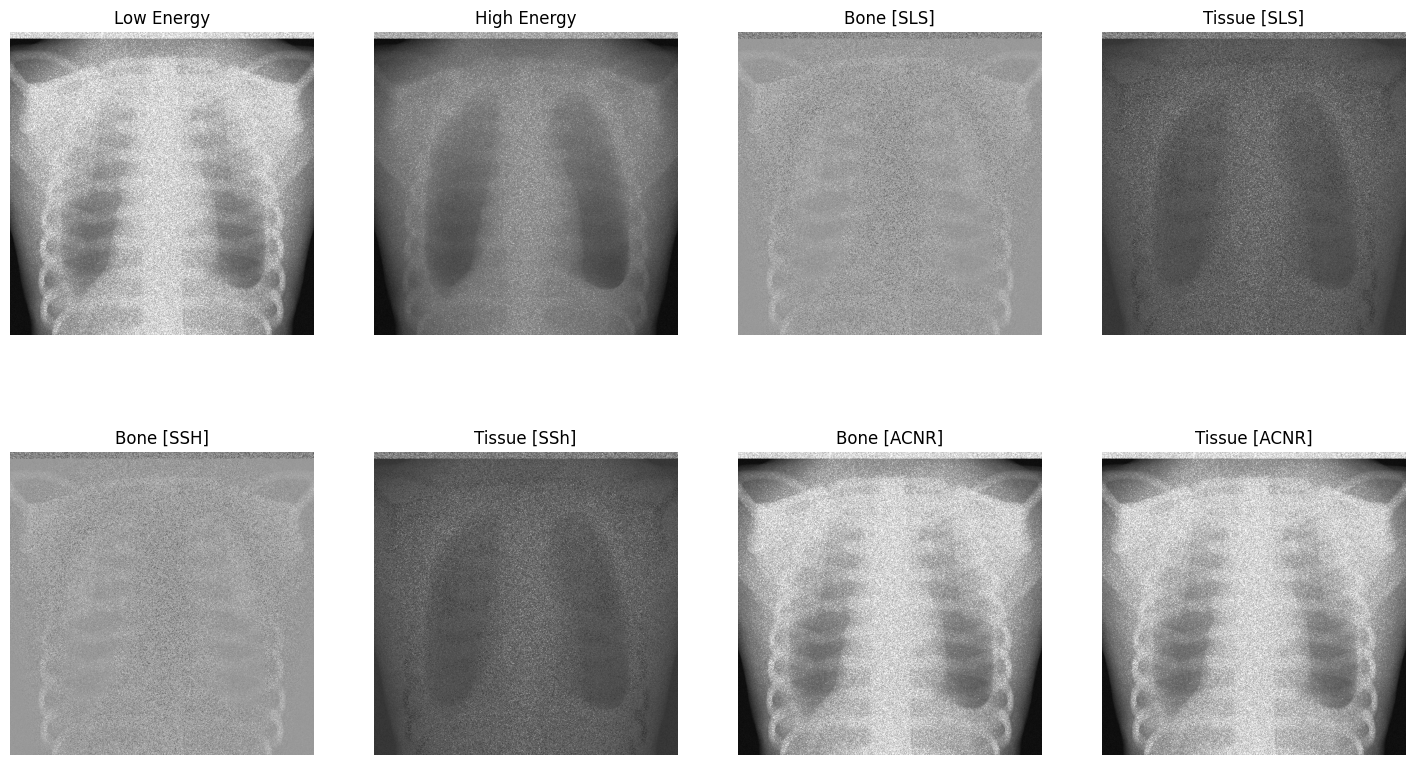

In [8]:
# PLOT HEATMAPS

import Radiography_Library as RadLib

sg = 0

sigma1 = sg
sigma2 = sg
wn = 0.0

save_in = ''
save_as_1 = ''
save_as_2 = ''
save_as_3 = ''
save_as_4 = ''
save_as_5 = ''
save_as_6 = ''
save_as_7 = ''
save_as_8 = ''

SLS_Bone, SSH_Bone, ACNR_Bone, ACNR_SSH_Bone = RadLib.IsolateTissues(
    low_energy_img, high_energy_img, sigma1, sigma2, wn, save_in, save_as_1, save_as_2, save_as_3, save_as_4, save_as_5, save_as_6, save_as_7, save_as_8)

## 4.2. Bone Mineral Density (BMD)

In [ ]:
import Radiography_Library as RadLib
thickness_bone = RadLib.BMO(SLS_Bone, SLS_Tissue)

Plot Interactive Heatmap

In [ ]:
import plotly.graph_objects as go; import plotly.io as pio

fig = go.Figure(go.Heatmap(z = thickness_bone, x = xlim, y = ylim))
fig.update_layout(width = 400, height = 400, xaxis = dict(autorange = 'reversed'), yaxis = dict(autorange = 'reversed'))    
fig.show()

## 5.1. Calculate Interactive CNR

Trim Image

In [ ]:
from PIL import Image; import matplotlib.pyplot as plt

directory = 'RESULTS/'
image = 'ssh' + '.png'
image = Image.open(directory + image)
image = image.convert('L')

print(image.size)
width = image.width; height = image.height

trim = 200
# image = image.crop((trim, trim, width - trim, height - trim)) # left, top, right, bottom
# image = image.crop((8410, trim, width - 60, height - trim))

# plt.imshow(image, cmap='gray'); plt.axis('off'); plt.show()

Launch Interactive CNR

In [ ]:
%matplotlib widget 
%matplotlib tk
import Radiography_Library as RadLib

RadLib.Interactive_CNR(image)

## 5.2. Calculate Fixed CNR 

In [ ]:
import Radiography_Library as RadLib

image_path = "RESULTS/" + "a" + ".png"
save_as = ''

shftx_s = 0.0 # shift x-coordinate signal box
shfty_s = 0.0 
shftx_b = 200.0 # shift x-coordinate background box
shfty_b = 0.0

coords_signal  = [1200 + shftx_s, 1000 + shfty_s, 1800 + shftx_s, 1800 + shfty_s] # x1, y1, x2, y2
coords_bckgrnd = [2100 + shftx_b, 1000 + shfty_b, 2300 + shftx_b, 1800 + shfty_b] # x1, y1, x2, y2

RadLib.Fixed_CNR(image_path, save_as, coords_signal, coords_bckgrnd)

## 6.1. Denoise with Skimage.Denoise_Bilateral

In [ ]:
import Radiography_Library as RadLib

# load array
path = SSH_Bone
isArray = True

# or load image
if isArray == False:
    directory = 'RESULTS/'
    path = directory + 'a' + '.png'

sigma_color = 0.05
sigma_spatial = 20

Denoised_Image = RadLib.Denoise_EdgeDetection(path, isArray)

## 6.2. Denoise by Fourier Transform

In [ ]:
import Radiography_Library as RadLib

array = htmp_array
isHann = False

alpha = 1

save_as = ''
isCrossSection = False # plot crosss-section

fft_image = RadLib.Denoise(array, isHann, alpha, save_as, isCrossSection)

## 7. Save Plotly Heatmap

In [ ]:
import Radiography_Library as RadLib

# array = htmp_array
# array = Denoised_Image
array = ACNR_Bone

title   = r"$ \large{ \text{Denoised Isolated Bone, DEXA: 40, 80 keV, 250M Beams} } $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

annotation = 'CNR = 9.1' 

width  = 800
height = 800

save_as = ''

RadLib.Plotly_Heatmap(array, xlim, ylim, title, x_label, y_label, annotation, width, height, save_as)

In [ ]:
def Plotly_Heatmap(array, xlim, ylim, title, x_label, y_label, annotation, width, height, save_as):

    import plotly.graph_objects as go
    import plotly.io as pio

    font_family = 'Merriweather'
    family_2    = 'Optima'
    font_small  = 18
    font_medium = 20
    font_large  = 18

    fig = go.Figure(go.Heatmap(z = array, x = xlim, y = ylim,
                                colorscale = [[0, 'black'], [1, 'white']], showscale = False,
                                colorbar = dict(title = "Density", tickfont = dict(family = family_2, size = 15, color = 'Black'))))
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = family_2, size = font_small, color = "Black"), title_standoff = 25, range=[max(xlim), min(xlim)]),
                    yaxis = dict(tickfont = dict(family = family_2, size = font_small, color = "Black"), title_standoff = 10, range=[max(xlim), min(xlim)],
                                 showticklabels = False
                                ),
                    width = width, height = height, margin = dict(l = 105, r = 90, t = 90, b = 90),
                    annotations = [dict(x = 0.95, y = 0.15,  xref = 'paper', yref = 'paper', showarrow = False,
                                        font = dict(family = family_2, size = 18, color = "White"),
                                        bgcolor = "rgba(255, 255, 255, 0.1)", borderpad = 8, bordercolor = "White", borderwidth = 0.2,
                                        text = annotation)])

    fig.add_shape(type = "rect", line = dict(color = "blue", width = 2), fillcolor = "rgba(0, 0, 0, 0)",
                  x0 = 10, y0 = 10, x1 = -10, y1 = -10) 
    
    fig.add_shape(type = "rect", line = dict(color = "red", width = 2), fillcolor = "rgba(0, 0, 0, 0)",
                  x0 = 20, y0 = 20, x1 = -20, y1 = -20) 
   
    if save_as != '': pio.write_image(fig, save_as + '.png', width = width, height = height, scale = 5)
    fig.show()


array = low_energy_img
array = ACNR_SSH_Bone

title   = r"$ \large{ \text{Low energy projection (40 keV), 100M Photons} } $"
title   = r"$ \large{ \text{ACNR projection (40, 80 keV), 100M Photons} } $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"
y_label = ''

annotation = 'CNR = ' 

width  = 700
height = 700

save_as = ''

Plotly_Heatmap(array, xlim, ylim, title, x_label, y_label, annotation, width, height, save_as)

# CT Scan

## Calculate projections at every angle from roots and save to CSV

In [ ]:
import Radiography_Library as RadLib; import matplotlib.pyplot as plt

directory = '/Volumes/GIECC/Geant4/CT/CT3/Roots'
roots = [0, 360, 1] # start, end, degree step

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

dimensions = [250, 75, 0, 150] # sizeX, sizeY, shiftX, shiftY, # in mm

pixel_size = 0.5 # in mm

csv_folder = "/Volumes/GIECC/Geant4/CT/CT3/CSV_raw"

htmp, xlim, ylim = RadLib.Calculate_Projections(directory, roots, tree_name, x_branch, y_branch, dimensions, log_factor, pixel_size, csv_folder)

plt.figure(figsize = (14, 4));  plt.subplot(1, 2, 1); plt.imshow(htmp, cmap = 'gray');  plt.subplot(1, 2, 2); plt.plot(htmp[htmp.shape[0]//2,:]); plt.show()

## Load projections from CSV and perfrom CT reconstruction

In [ ]:
import Radiography_Library as RadLib
import numpy as np

roots = [0, 360, 1] # start, end, degree step
csv_folder = '/Volumes/GIECC/Geant4/CT/CT3/CSV_raw'
radiographs = RadLib.htmps_from_csv(csv_folder, roots)

log_factor = 1e-10
pixel_size = 0.5
htmps = RadLib.LogaritmicTransformation(radiographs, log_factor, pixel_size)

# slices = 1
# reconstruction = RadLib.RadonReconstruction(roots, htmps, slices)

# mu_water = 0.26748 # 40kev
# mu_water = 0.18443 # 80kev
# HU_images = RadLib.coefficients_to_HU(reconstruction, slices, mu_water)

In [ ]:
def RadonReconstruction(roots, htmps, slices):

    from skimage.transform import iradon
    import numpy as np; import matplotlib.pyplot as plt
    import plotly.graph_objects as go; import plotly.io as pio
    from tqdm import tqdm

    height = len(htmps[0])
    n = height/(slices)
    heights = np.round(np.arange(n, height, n)).astype(int)

    start = roots[0]
    end = roots[1]
    deg = roots[2]

    thetas = np.arange(start, end+1, deg)
    reconstructed_imgs = np.zeros(slices, dtype="object")

    for i, layer in tqdm(enumerate(heights), desc = 'Reconstructing slices', unit = ' Slices', leave = True):

        p = np.array([heatmap[layer] for heatmap in htmps]).T
        reconstructed_imgs[i] = iradon(p, theta = thetas)
        reconstructed_imgs[i][reconstructed_imgs[i] < -0.1] = 0
        reconstructed_imgs[i][reconstructed_imgs[i] > 1.5] = 0

    # plt.figure(figsize = (6,6)); plt.imshow(reconstructed_imgs[slices//2], cmap = 'gray'); plt.colorbar(); plt.show()
    
    fig = go.Figure(go.Heatmap(z = reconstructed_imgs[0]))
    fig.update_layout(width = 800, height = 800, xaxis = dict(autorange = 'reversed'), yaxis = dict(autorange = 'reversed'))
    fig.show()

    return reconstructed_imgs

slices = 10
reconstruction = RadonReconstruction(roots, htmps, slices)

In [ ]:
mu_water = 0.26748 # 40kev
mu_water = 0.18443 # 80kev
HU_images = RadLib.coefficients_to_HU(reconstruction, slices, mu_water)

## Export to DICOM

In [ ]:
directory = 'RESULTS/DICOM'
dimensions = [250, 75, 0, 150]
size_y = dimensions[1]
RadLib.export_to_dicom(HU_images, size_y, slices, directory)